  **Overview: Purpose of this notebook is to explore the targeted privacy tests and run simple logistic regression model.**

* Preprocessing the json data and converting it into tabular format.

In [1]:
# load json file into pandas dataframe
import pandas as pd
import json

json_data = open("../data/sample_data_1125.json").read()
data = json.loads(json_data)
df = pd.DataFrame(data)

# expand column of dictionaries into separate columns
df = pd.concat(
    [df.drop(["genconfig"], axis=1), df["genconfig"].apply(pd.Series)], axis=1
)
df = pd.concat([df.drop(["metadata"], axis=1), df["metadata"].apply(pd.Series)], axis=1)
# drop unnecessary columns
df.drop(["quality", "product_version", "runtime_end"], axis=1, inplace=True)

# for each unique schema, create a new column called schema_id
df["schema_str"] = df["schema"].apply(lambda x: str(x) if isinstance(x, list) else x)
df["schema_id"] = df["schema_str"].factorize()[0]

df.head()

,schema,privacy,type,epochs,learning_rate,batch_size,row_count,table_names,schema_str,schema_id
0,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0
1,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltTVAE,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",1
2,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCopulaGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",1
3,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",1
4,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCopulaGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0


In [2]:
df["table_names"].value_counts()

table_names
nursery                      27
healthcare_dataset           12
applications                  9
credit_card_sample            6
StudentPerformanceFactors     3
indicators                    1
Name: count, dtype: int64

* Extract the schema of the json data and create a tabular data for further analysis.

In [3]:
df_schema = pd.concat(
    [
        pd.DataFrame(df["schema"][i]).assign(
            schema_id=df["schema_id"][i],
            table_names=df["table_names"][i],
            type=df["type"][i],
        )
        for i in range(len(df["schema"]))
    ]
)

df_schema.head()

/var/folders/xr/lfv3bx8j69x4n2wzsd6ryvp40000gn/T/ipykernel_60761/1574349799.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_schema = pd.concat(


,name,type,synthesize_as,indirect_identifier,direct_identifier,null_ratio,unique_values,min_value,max_value,schema_id,table_names
0,parents,SubsaltCTGAN,categorical,True,False,0.0,3.0,NaN,NaN,0,nursery
1,has_nurs,SubsaltCTGAN,categorical,True,False,0.0,5.0,NaN,NaN,0,nursery
2,form,SubsaltCTGAN,categorical,True,False,0.0,4.0,NaN,NaN,0,nursery
3,children,SubsaltCTGAN,categorical,True,False,0.0,4.0,NaN,NaN,0,nursery
4,housing,SubsaltCTGAN,categorical,True,False,0.0,3.0,NaN,NaN,0,nursery


In [4]:
# check the NaN values ratio
df_schema.isnull().sum() / len(df_schema)

name                   0.000000
type                   0.000000
synthesize_as          0.082386
indirect_identifier    0.000000
direct_identifier      0.000000
null_ratio             0.292614
unique_values          0.082386
min_value              0.627841
max_value              0.627841
schema_id              0.000000
table_names            0.000000
dtype: float64

In [5]:
df_schema["synthesize_as"].value_counts()

synthesize_as
categorical    381
int            153
float           52
binary          48
datetime        12
Name: count, dtype: int64

In [6]:
df_schema.describe()

,null_ratio,unique_values,min_value,max_value,schema_id
count,498.000000,646.000000,262.000000,262.000000,704.000000
mean,0.000192,1280.506192,1429.359542,27102.979771,8.745739
std,0.000920,14851.012094,6903.971076,82921.873429,5.012004
min,0.000000,2.000000,-100.000000,1.000000,0.000000
25%,0.000000,3.000000,1.000000,14.000000,4.000000
50%,0.000000,5.000000,12.000000,100.000000,9.000000
75%,0.000000,45.000000,70.000000,850.000000,13.000000
max,0.004920,218133.000000,37900.000000,448929.000000,17.000000


In [7]:
def calculate_schema(schema):
    num_variables = len(schema)
    num_indirect_identifier = sum(
        1 for i_identifier in schema if i_identifier.get("indirect_identifier", False)
    )
    num_categorical = sum(
        1 for categorical in schema if categorical.get("synthesize_as") == "categorical"
    )
    num_high_unique_values_categorical = sum(
        1
        for categorical_high in schema
        if categorical_high.get("synthesize_as") == "categorical"
        and categorical_high.get("unique_values", 0) > 5
    )
    mean_unique_values_categorical = (
        sum(
            categorical.get("unique_values", 0)
            for categorical in schema
            if categorical.get("synthesize_as") == "categorical"
        )
        / num_categorical
        if num_categorical > 0
        else 0
    )
    return (
        num_variables,
        num_indirect_identifier,
        num_categorical,
        num_high_unique_values_categorical,
        mean_unique_values_categorical,
    )


# Apply the function to each schema and create a new DataFrame with the results
df[
    [
        "num_variables",
        "num_indirect_identifier",
        "num_categorical",
        "num_high_unique_values_categorical",
        "mean_unique_values_categorical",
    ]
] = df["schema"].apply(lambda schema: pd.Series(calculate_schema(schema)))

df.head()

,schema,privacy,type,epochs,learning_rate,batch_size,row_count,table_names,schema_str,schema_id,num_variables,num_indirect_identifier,num_categorical,num_high_unique_values_categorical,mean_unique_values_categorical
0,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,0.0,3.75
1,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltTVAE,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",1,10.0,2.0,8.0,0.0,3.75
2,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCopulaGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",1,10.0,2.0,8.0,0.0,3.75
3,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",1,10.0,2.0,8.0,0.0,3.75
4,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCopulaGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,0.0,3.75


In [8]:
# add a new column for the actual train row count, it is the minimum of row_count and 400000

df["train_row_count"] = df["row_count"].apply(lambda x: min(x, 400_000))

In [9]:
df.describe()

,learning_rate,batch_size,row_count,schema_id,num_variables,num_indirect_identifier,num_categorical,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count
count,5.800000e+01,58.0,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,2.000000e-04,50000.0,125058.982759,7.844828,12.137931,6.706897,6.568966,1.172414,2390.982140,62990.017241
std,2.734178e-20,0.0,302027.186274,4.976442,3.186861,5.008794,3.049947,1.568751,9981.921165,121145.150808
min,2.000000e-04,50000.0,5000.000000,0.000000,10.000000,1.000000,1.000000,0.000000,2.777778,5000.000000
25%,2.000000e-04,50000.0,12960.000000,3.250000,10.000000,2.500000,4.250000,0.000000,3.750000,12960.000000
50%,2.000000e-04,50000.0,12960.000000,8.000000,11.000000,5.000000,8.000000,0.000000,3.750000,12960.000000
75%,2.000000e-04,50000.0,25000.000000,12.000000,14.000000,10.000000,8.000000,2.750000,9.833333,25000.000000
max,2.000000e-04,50000.0,1000000.000000,17.000000,23.000000,20.000000,18.000000,4.000000,44740.600000,400000.000000


In [10]:
# concantenate all df["privacy"] into a single dataframe
df_privacy = pd.concat(
    [pd.DataFrame(df["privacy"][i]) for i in range(len(df["privacy"]))]
)
df_privacy

,name,threshold,score,passed
0,Minimum row count,3000.00,12960.000000,True
1,Check distance distributions between real and ...,0.05,0.331952,True
2,Membership inference,0.55,0.506659,True
3,Risky row counts,123.12,2575.000000,False
4,Row memorization,0.05,0.325211,False
...,...,...,...,...
2,Membership inference,0.55,0.501889,True
3,Row memorization,0.05,0.000000,True
4,Risky row counts,1775.76,27.000000,True
5,No new categorical values,0.00,0.000000,True


In [11]:
df_privacy["name"].value_counts()

name
Minimum row count                                          58
Check distance distributions between real and synthetic    58
Membership inference                                       58
Risky row counts                                           58
Row memorization                                           58
Attribute inference                                        58
No new categorical values                                  58
Name: count, dtype: int64

In [12]:
# replicate the rows of the original dataframe
df = df.loc[df.index.repeat(df["privacy"].str.len())].reset_index(drop=True)
df.head()

,schema,privacy,type,epochs,learning_rate,batch_size,row_count,table_names,schema_str,schema_id,num_variables,num_indirect_identifier,num_categorical,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count
0,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,0.0,3.75,12960
1,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,0.0,3.75,12960
2,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,0.0,3.75,12960
3,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,0.0,3.75,12960
4,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,0.0,3.75,12960


In [13]:
# split the privacy column into separate columns
for i in df_privacy.columns:
    df[i] = df_privacy[i].values
# drop the privacy column
df.drop(["privacy"], axis=1, inplace=True)
df.head(7)

,schema,type,epochs,learning_rate,batch_size,row_count,table_names,schema_str,schema_id,num_variables,num_indirect_identifier,num_categorical,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count,name,threshold,score,passed
0,"[{'name': 'parents', 'type': 'string', 'synthe...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,0.0,3.75,12960,Minimum row count,3000.00,12960.000000,True
1,"[{'name': 'parents', 'type': 'string', 'synthe...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,0.0,3.75,12960,Check distance distributions between real and ...,0.05,0.331952,True
2,"[{'name': 'parents', 'type': 'string', 'synthe...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,0.0,3.75,12960,Membership inference,0.55,0.506659,True
3,"[{'name': 'parents', 'type': 'string', 'synthe...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,0.0,3.75,12960,Risky row counts,123.12,2575.000000,False
4,"[{'name': 'parents', 'type': 'string', 'synthe...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,0.0,3.75,12960,Row memorization,0.05,0.325211,False
5,"[{'name': 'parents', 'type': 'string', 'synthe...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,0.0,3.75,12960,Attribute inference,0.10,0.000000,True
6,"[{'name': 'parents', 'type': 'string', 'synthe...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,0.0,3.75,12960,No new categorical values,0.00,0.000000,True


In [14]:
# drop the schema column
df.drop(["schema", "schema_str"], axis=1, inplace=True)
df.sample()

,type,epochs,learning_rate,batch_size,row_count,table_names,schema_id,num_variables,num_indirect_identifier,num_categorical,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count,name,threshold,score,passed
391,SubsaltCopulaGAN,100,0.0002,50000,1000000,healthcare_dataset,16,15.0,14.0,4.0,2.0,1392.5,400000,Attribute inference,0.1,0.0,True


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   type                                406 non-null    object 
 1   epochs                              406 non-null    object 
 2   learning_rate                       406 non-null    float64
 3   batch_size                          406 non-null    int64  
 4   row_count                           406 non-null    int64  
 5   table_names                         406 non-null    object 
 6   schema_id                           406 non-null    int64  
 7   num_variables                       406 non-null    float64
 8   num_indirect_identifier             406 non-null    float64
 9   num_categorical                     406 non-null    float64
 10  num_high_unique_values_categorical  406 non-null    float64
 11  mean_unique_values_categorical      406 non-n

In [16]:
df.describe()

,learning_rate,batch_size,row_count,schema_id,num_variables,num_indirect_identifier,num_categorical,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count,threshold,score
count,406.0000,406.0,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,0.0002,50000.0,125058.982759,7.844828,12.137931,6.706897,6.568966,1.172414,2390.982140,62990.017241,514.846034,13865.202259
std,0.0000,0.0,299781.599836,4.939442,3.163166,4.971554,3.027271,1.557087,9907.705108,120244.430873,1129.734019,88958.844471
min,0.0002,50000.0,5000.000000,0.000000,10.000000,1.000000,1.000000,0.000000,2.777778,5000.000000,0.000000,0.000000
25%,0.0002,50000.0,12960.000000,3.000000,10.000000,2.000000,4.000000,0.000000,3.750000,12960.000000,0.050000,0.000000
50%,0.0002,50000.0,12960.000000,8.000000,11.000000,5.000000,8.000000,0.000000,3.750000,12960.000000,0.100000,0.000081
75%,0.0002,50000.0,25000.000000,12.000000,14.000000,10.000000,8.000000,3.000000,11.000000,25000.000000,123.120000,0.526219
max,0.0002,50000.0,1000000.000000,17.000000,23.000000,20.000000,18.000000,4.000000,44740.600000,400000.000000,4001.790000,727599.000000


In [17]:
df["epochs"].value_counts()

epochs
100    406
Name: count, dtype: int64

* It is observed that the hyperparameter of learning rate, epoches and batch size are same for all the datasets. So, we will not consider them columns for current analysis.

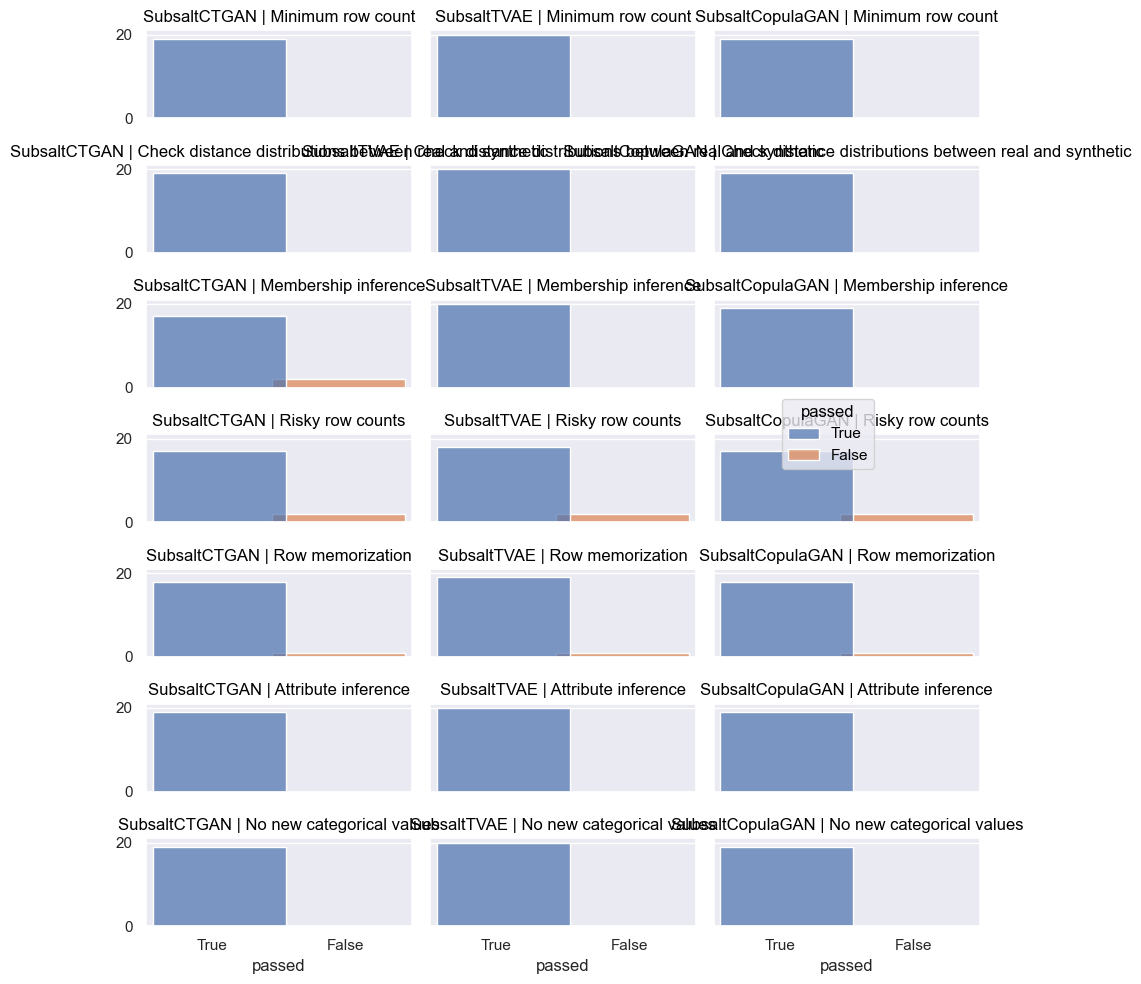

In [18]:
import seaborn.objects as so

plot = (
    so.Plot(df, x="passed", color="passed")
    .facet(col="type", row="name")
    .add(so.Bars(), so.Hist())
    .layout(size=(9, 10))
)
plot.show()

* Based on the sample data showed above, the privacy tests fail more likely are `Risky row counts`, `Membership inference`, `Row memorization`.

In [19]:
df_failed = df[df["passed"] == False]
df_failed

,type,epochs,learning_rate,batch_size,row_count,table_names,schema_id,num_variables,num_indirect_identifier,num_categorical,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count,name,threshold,score,passed
3,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,0.0,3.750000,12960,Risky row counts,123.12,2575.000000,False
4,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,0.0,3.750000,12960,Row memorization,0.05,0.325211,False
31,SubsaltCopulaGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,0.0,3.750000,12960,Risky row counts,123.12,2617.000000,False
32,SubsaltCopulaGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,0.0,3.750000,12960,Row memorization,0.05,0.325292,False
37,SubsaltTVAE,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,0.0,3.750000,12960,Risky row counts,123.12,2821.000000,False
39,SubsaltTVAE,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,0.0,3.750000,12960,Row memorization,0.05,0.688596,False
170,SubsaltTVAE,100,0.0002,50000,12960,nursery,7,10.0,7.0,8.0,0.0,3.750000,12960,Risky row counts,123.12,638.000000,False
178,SubsaltCopulaGAN,100,0.0002,50000,12960,nursery,7,10.0,7.0,8.0,0.0,3.750000,12960,Risky row counts,123.12,673.000000,False
185,SubsaltCTGAN,100,0.0002,50000,12960,nursery,7,10.0,7.0,8.0,0.0,3.750000,12960,Risky row counts,123.12,744.000000,False
289,SubsaltCTGAN,100,0.0002,50000,100000,healthcare_dataset,13,12.0,11.0,3.0,1.0,6.333333,100000,Membership inference,0.55,0.569136,False


In [20]:
for table_names in df_failed["table_names"].unique():
    for name in df_failed[df_failed["table_names"] == table_names]["name"].unique():
        for type in df_failed[df_failed["table_names"] == table_names]["type"].unique():
            print(f"table names: {table_names}, Privacy test: {name}, Type: {type}")
            print(
                df[
                    (df["table_names"] == table_names)
                    & (df["name"] == name)
                    & (df["type"] == type)
                ][
                    [
                        # "type",
                        "epochs",
                        "row_count",
                        "passed",
                        "schema_id",
                        "score",
                        "threshold",
                    ]
                ]
            )

table names: nursery, Privacy test: Risky row counts, Type: SubsaltCTGAN
    epochs  row_count  passed  schema_id   score  threshold
3      100      12960   False          0  2575.0     123.12
24     100      12960    True          1     0.0     123.12
59     100      12960    True          2     0.0     123.12
73     100      12960    True          3     0.0     123.12
87     100      12960    True          4     0.0     123.12
107    100      12960    True          2     0.0     123.12
143    100      12960    True          5     4.0     123.12
157    100      12960    True          6     0.0     123.12
185    100      12960   False          7   744.0     123.12
table names: nursery, Privacy test: Risky row counts, Type: SubsaltCopulaGAN
    epochs  row_count  passed  schema_id   score  threshold
17     100      12960    True          1     0.0     123.12
31     100      12960   False          0  2617.0     123.12
51     100      12960    True          2     0.0     123.12
93     100

In [21]:
df["ratio_indirect_identifier"] = df["num_indirect_identifier"] / df["num_variables"]
df["ratio_categorical"] = df["num_categorical"] / df["num_variables"]

In [22]:
df.head()

,type,epochs,learning_rate,batch_size,row_count,table_names,schema_id,num_variables,num_indirect_identifier,num_categorical,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count,name,threshold,score,passed,ratio_indirect_identifier,ratio_categorical
0,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,0.0,3.75,12960,Minimum row count,3000.00,12960.000000,True,0.9,0.8
1,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,0.0,3.75,12960,Check distance distributions between real and ...,0.05,0.331952,True,0.9,0.8
2,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,0.0,3.75,12960,Membership inference,0.55,0.506659,True,0.9,0.8
3,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,0.0,3.75,12960,Risky row counts,123.12,2575.000000,False,0.9,0.8
4,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,0.0,3.75,12960,Row memorization,0.05,0.325211,False,0.9,0.8


* Create subset of data for three target privacy tests.

In [23]:
df_risky_row_counts = df[df["name"] == "Risky row counts"]

In [24]:
df_row_memorization = df[df["name"] == "Row memorization"]

In [25]:
df_membership_inference = df[df["name"] == "Membership inference"]

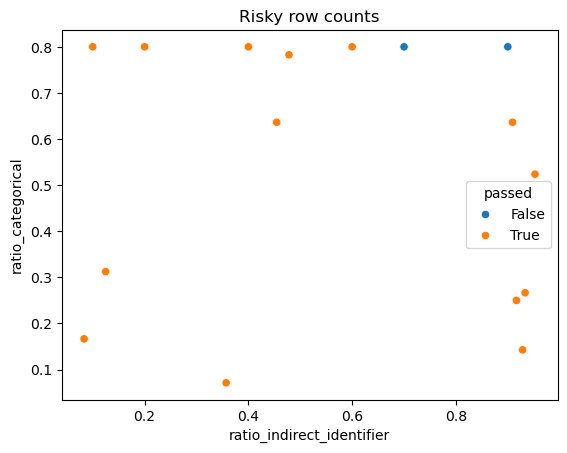

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.scatterplot(
    data=df_risky_row_counts,
    x="ratio_indirect_identifier",
    y="ratio_categorical",
    hue="passed",
).title.set_text("Risky row counts")
plt.show()

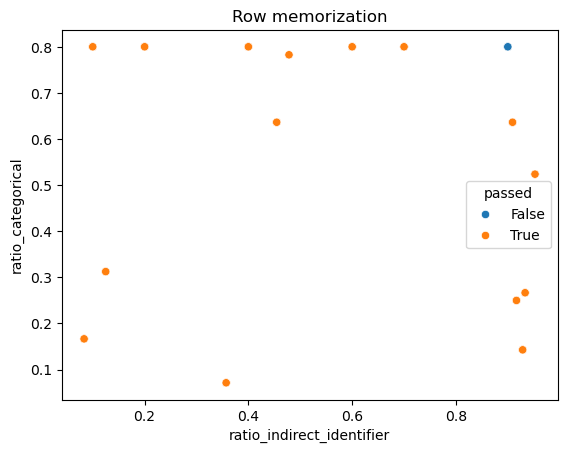

In [27]:
sns.scatterplot(
    data=df_row_memorization,
    x="ratio_indirect_identifier",
    y="ratio_categorical",
    hue="passed",
).title.set_text("Row memorization")
plt.show()

**Note: It seems a simple logistic regression can classsify the result for row memorization and risky row count tests**

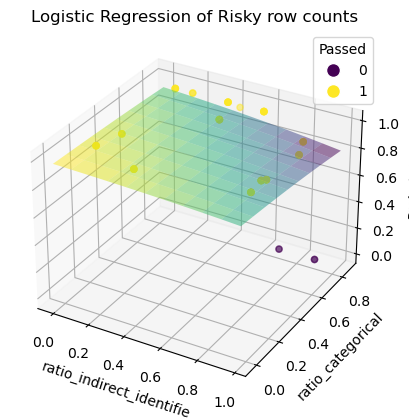

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression

X = df_risky_row_counts[["ratio_indirect_identifier", "ratio_categorical"]].values
y = df_risky_row_counts["passed"].astype(int)

# Train the model
model = LogisticRegression()
model.fit(X, y)

# Generate a grid of points for plotting
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict probabilities for the grid points
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], y, c=y)
ax.plot_surface(xx, yy, Z, cmap="viridis", alpha=0.5)
ax.set_xlabel("ratio_indirect_identifie")
ax.set_ylabel("ratio_categorical")
ax.set_zlabel("Probability")
ax.set_title("Logistic Regression of Risky row counts")

# Create legend
legend_labels = np.unique(y)
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=plt.cm.viridis(i / max(legend_labels)),
        markersize=10,
        label=f"{i}",
    )
    for i in legend_labels
]
ax.legend(handles=handles, title="Passed", loc="best")

plt.show()

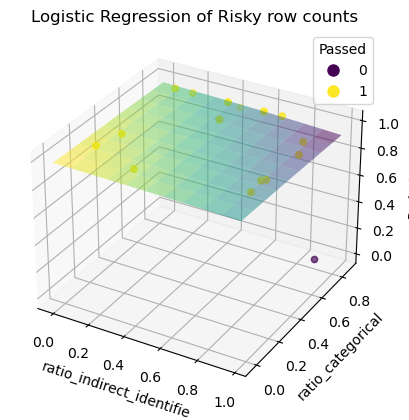

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression

X = df_row_memorization[["ratio_indirect_identifier", "ratio_categorical"]].values
y = df_row_memorization["passed"].astype(int)

# Train the model
model = LogisticRegression()
model.fit(X, y)

# Generate a grid of points for plotting
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict probabilities for the grid points
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], y, c=y)
ax.plot_surface(xx, yy, Z, cmap="viridis", alpha=0.5)
ax.set_xlabel("ratio_indirect_identifie")
ax.set_ylabel("ratio_categorical")
ax.set_zlabel("Probability")
ax.set_title("Logistic Regression of Risky row counts")

# Create legend
legend_labels = np.unique(y)
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=plt.cm.viridis(i / max(legend_labels)),
        markersize=10,
        label=f"{i}",
    )
    for i in legend_labels
]
ax.legend(handles=handles, title="Passed", loc="best")

plt.show()

* Now let's have a look into membership inference test.

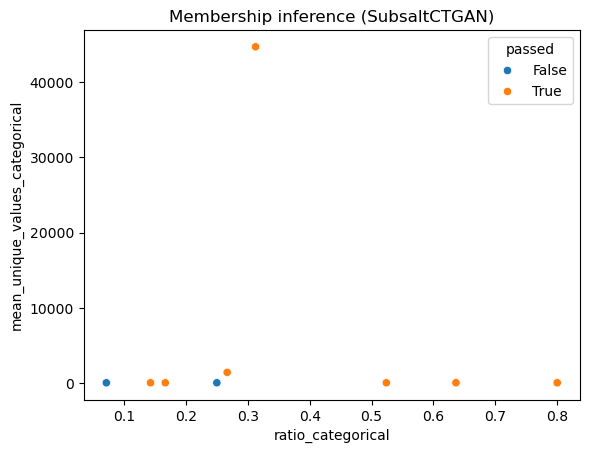

In [30]:
sns.scatterplot(
    data=df_membership_inference[df_membership_inference["type"] == "SubsaltCTGAN"],
    x="ratio_categorical",
    y="mean_unique_values_categorical",
    hue="passed",
).title.set_text("Membership inference (SubsaltCTGAN)")
plt.show()

* Look into the credit card dataset, #10 passed and #14 failed the membership inference test.

In [31]:
df_schema[(df_schema["schema_id"] == 10) & (df_schema["type"] == "SubsaltCTGAN")]

,name,type,synthesize_as,indirect_identifier,direct_identifier,null_ratio,unique_values,min_value,max_value,schema_id,table_names
0,year,SubsaltCTGAN,int,True,False,0.0,28.0,1993.0,2020.00,10,credit_card_sample
1,month,SubsaltCTGAN,int,True,False,0.0,12.0,1.0,12.00,10,credit_card_sample
2,day,SubsaltCTGAN,int,True,False,0.0,31.0,1.0,31.00,10,credit_card_sample
3,amount,SubsaltCTGAN,float,True,False,0.0,3667.0,-100.0,1895.45,10,credit_card_sample
4,UseChip,SubsaltCTGAN,categorical,True,False,0.0,3.0,NaN,NaN,10,credit_card_sample
5,gender,SubsaltCTGAN,binary,True,False,0.0,2.0,NaN,NaN,10,credit_card_sample
6,birth_year,SubsaltCTGAN,int,True,False,0.0,79.0,1918.0,2002.00,10,credit_card_sample
7,birth_month,SubsaltCTGAN,int,True,False,0.0,12.0,1.0,12.00,10,credit_card_sample
8,annual_income,SubsaltCTGAN,int,True,False,0.0,1634.0,1.0,280199.00,10,credit_card_sample
9,demographics_income_per_capita,SubsaltCTGAN,int,True,False,0.0,1507.0,0.0,163145.00,10,credit_card_sample


In [32]:
df_schema[(df_schema["schema_id"] == 14) & (df_schema["type"] == "SubsaltCTGAN")]

,name,type,synthesize_as,indirect_identifier,direct_identifier,null_ratio,unique_values,min_value,max_value,schema_id,table_names
0,credit_swipes_credit_card_sample_year,SubsaltCTGAN,int,False,False,NaN,28.0,1993.0,2020.00,14,credit_card_sample
1,credit_swipes_credit_card_sample_month,SubsaltCTGAN,int,True,False,NaN,12.0,1.0,12.00,14,credit_card_sample
2,credit_swipes_credit_card_sample_day,SubsaltCTGAN,int,False,False,NaN,31.0,1.0,31.00,14,credit_card_sample
3,credit_swipes_credit_card_sample_amount,SubsaltCTGAN,float,False,False,NaN,3667.0,-100.0,1895.45,14,credit_card_sample
4,credit_swipes_credit_card_sample_UseChip,SubsaltCTGAN,categorical,True,False,NaN,3.0,NaN,NaN,14,credit_card_sample
5,credit_swipes_credit_card_sample_gender,SubsaltCTGAN,binary,True,False,NaN,2.0,NaN,NaN,14,credit_card_sample
6,credit_swipes_credit_card_sample_birth_year,SubsaltCTGAN,int,False,False,NaN,79.0,1918.0,2002.00,14,credit_card_sample
7,credit_swipes_credit_card_sample_birth_month,SubsaltCTGAN,int,False,False,NaN,12.0,1.0,12.00,14,credit_card_sample
8,credit_swipes_credit_card_sample_annual_income,SubsaltCTGAN,int,False,False,NaN,1634.0,1.0,280199.00,14,credit_card_sample
9,credit_swipes_credit_card_sample_demographics_...,SubsaltCTGAN,int,True,False,NaN,1507.0,0.0,163145.00,14,credit_card_sample


**Note: One difference: `num_credit_cards` is `categorical` in dataset #10 (passed) while it is `numerical` in dataset #14 (failed).**

* Look into the healthcare dataset, #12 passed and #13 failed the membership inference test.

In [33]:
df_schema[(df_schema["schema_id"] == 12) & (df_schema["type"] == "SubsaltCTGAN")]

,name,type,synthesize_as,indirect_identifier,direct_identifier,null_ratio,unique_values,min_value,max_value,schema_id,table_names
0,Date,SubsaltCTGAN,datetime,False,False,0.0,364.0,NaN,NaN,12,healthcare_dataset
1,HeartRate,SubsaltCTGAN,int,False,False,0.0,41.0,60.0,100.0,12,healthcare_dataset
2,Temperature,SubsaltCTGAN,float,False,False,0.0,15.0,36.1,37.5,12,healthcare_dataset
3,Cholesterol,SubsaltCTGAN,int,False,False,0.0,151.0,150.0,300.0,12,healthcare_dataset
4,Glucose,SubsaltCTGAN,int,False,False,0.0,131.0,70.0,200.0,12,healthcare_dataset
5,BMI,SubsaltCTGAN,float,False,False,0.0,166.0,18.5,35.0,12,healthcare_dataset
6,Weight,SubsaltCTGAN,float,False,False,0.0,751.0,45.0,120.0,12,healthcare_dataset
7,Height,SubsaltCTGAN,int,True,False,0.0,51.0,150.0,200.0,12,healthcare_dataset
8,RespiratoryRate,SubsaltCTGAN,int,False,False,0.0,9.0,12.0,20.0,12,healthcare_dataset
9,MedCondition,SubsaltCTGAN,categorical,False,False,0.0,5.0,NaN,NaN,12,healthcare_dataset


In [34]:
df_schema[(df_schema["schema_id"] == 13) & (df_schema["type"] == "SubsaltCTGAN")]

,name,type,synthesize_as,indirect_identifier,direct_identifier,null_ratio,unique_values,min_value,max_value,schema_id,table_names
0,Date,SubsaltCTGAN,datetime,True,False,0.0,364.0,NaN,NaN,13,healthcare_dataset
1,HeartRate,SubsaltCTGAN,int,True,False,0.0,41.0,60.0,100.0,13,healthcare_dataset
2,Temperature,SubsaltCTGAN,float,True,False,0.0,15.0,36.1,37.5,13,healthcare_dataset
3,Cholesterol,SubsaltCTGAN,int,True,False,0.0,151.0,150.0,300.0,13,healthcare_dataset
4,Glucose,SubsaltCTGAN,int,True,False,0.0,131.0,70.0,200.0,13,healthcare_dataset
5,BMI,SubsaltCTGAN,float,True,False,0.0,166.0,18.5,35.0,13,healthcare_dataset
6,Weight,SubsaltCTGAN,float,True,False,0.0,751.0,45.0,120.0,13,healthcare_dataset
7,Height,SubsaltCTGAN,int,True,False,0.0,51.0,150.0,200.0,13,healthcare_dataset
8,RespiratoryRate,SubsaltCTGAN,categorical,True,False,0.0,9.0,12.0,20.0,13,healthcare_dataset
9,MedCondition,SubsaltCTGAN,categorical,True,False,0.0,5.0,NaN,NaN,13,healthcare_dataset


**Note: One difference: `RespiratoryRate` is `numerical` in dataset #12 (passed) while it is `categorical` in dataset #13 (failed).**